# **Hypothesis: LSTM**

In [46]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
import pandas_datareader.data as web
import datetime

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Define which online source to use
data_source = 'yahoo'

# define start and end dates
start_date = '2018-01-01'
end_date = '2019-12-31'
symbol = 'ICICIBANK.NS'
#symbol = 'GAIL.NS'
#symbol = 'ONGC.NS'
# Use pandas_datareader.data.DataReader to load the desired data list(companies_dict.values()) used for python 3 compatibility
web.DataReader(symbol, data_source, start_date, end_date).to_csv(symbol+'.csv')
df = pd.read_csv(symbol+'.csv')
df = pd.DataFrame(df,columns=['Date','Open','High','Low','Close']).round(decimals=2)
df.head()

,Date,Open,High,Low,Close
0,2018-01-01,314.00,314.00,309.1,310.3
1,2018-01-02,310.95,311.70,307.5,309.7
2,2018-01-03,312.50,316.35,312.5,315.0
3,2018-01-04,314.95,315.65,311.5,314.7
4,2018-01-05,314.45,315.15,311.6,312.9


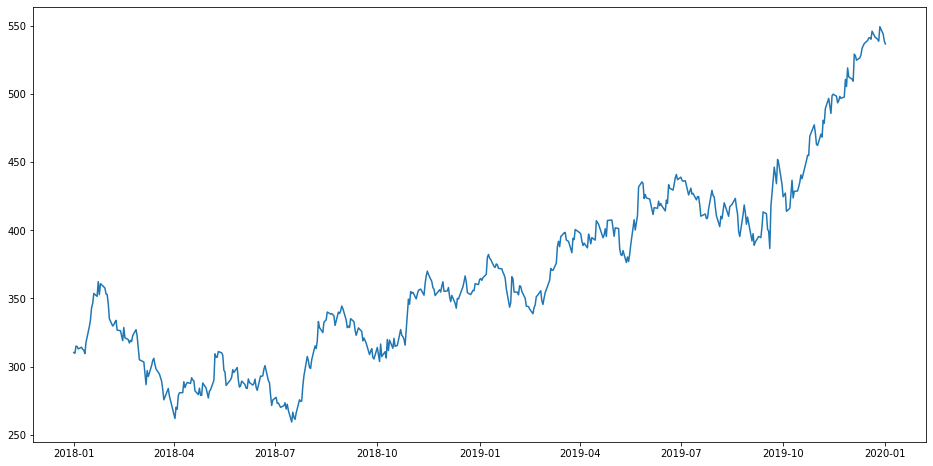

In [47]:
#creating a separate dataset
disdata = pd.DataFrame(df,columns=['Date','Open','High','Low','Close'])

#setting index as date
disdata['Date'] = pd.to_datetime(disdata.Date,format='%Y-%m-%d')
disdata.index = disdata['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(disdata['Close'], label='Close Price history')

In [48]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:339,:]
test = dataset[339:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
#X = model.evaluate(x_train,y_train,batch_size=1,verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

279/279 - 9s - loss: 0.0047


In [49]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(test, closing_price))  
print('Mean Squared Error:', metrics.mean_squared_error(test, closing_price))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test, closing_price)))

Mean Absolute Error: 39.84988199869792
Mean Squared Error: 1870.9238163325479
Root Mean Squared Error: 43.25417686573804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


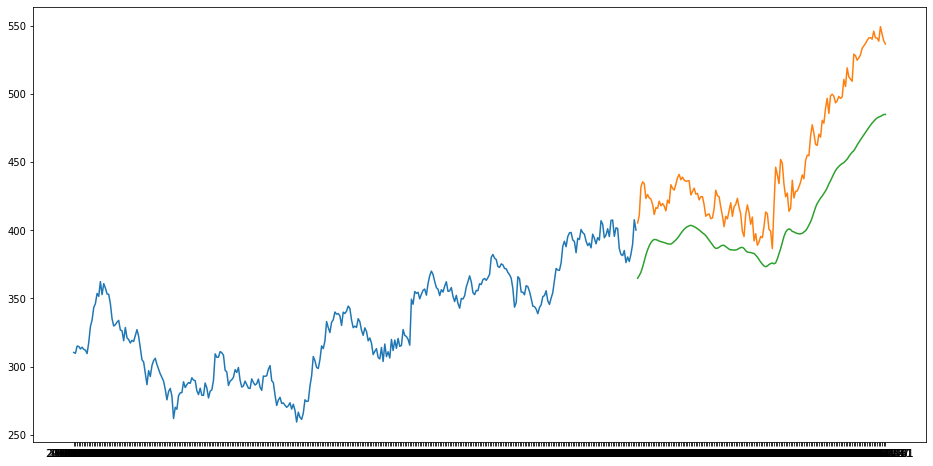

In [50]:
#for plotting
train = new_data[:339]
test = new_data[339:]
test['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])